# Introduction to Norse

This tutorial introduces [Norse](norse.ai) and the concept of spiking neurons.
In the next 5-10 minutes or so you will learn about

- Spiking Neuron Models
- Gradient based learning with Spiking Neurons

## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [144]:
!pip install norse --quiet

import torch
import norse
import numpy as np

## Step 1: A simple neuron model

The point neuron models supported by Norse are almost all variants of the Leaky-Integrate and Fire neuron model. It is however relatively easy to implement your own model. The library
is build in layers, here I show an example of how to use the functional API directly. To
build large scale machine learning models, you should check out the tutorial on [PyTorch
lightning + Norse](high-performance-computing.ipynb).


In [145]:
from norse.torch.functional.lif import lif_step, LIFParameters, LIFState

class Neurons(torch.nn.Module):
    def __init__(self, weights, alpha):
        super(Neurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        
        self.lambda_vs = []
        self.lambda_is = []
        self.p = LIFParameters(alpha=alpha)

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []

    def forward(self, z_in):
        seq_length, batch_size, _ = z_in.shape
        hidden_size = self.hidden_size

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)
        z_s = torch.zeros(seq_length, batch_size, hidden_size)

        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

        for ts in range(seq_length):
            z, s = lif_step(z_in[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            z_s[ts,:] = z

        return z_s, voltages, currents

## Step 2.1: Optimizing for a fixed number of spikes

A simple task to consider is a single neuron stimulated at different times by $k$ fixed poisson distributed spike trains, with synaptic weights distributed according to a gaussian distribution. The goal is for the neuron to respond to these fixed spike trains with a certain number of spikes $n_\text{target}$ within a time $T$. The loss in this case is
$$
l = -n_\text{target}/T + \sum_i \delta(t - t_i) 
$$
so
$$
S = \int_0^T (-n_\text{target}/T + \sum_i \delta(t - t_i)) dt = n_\text{actual} - n_\text{target}
$$

In [146]:
from tqdm.notebook import trange

def run_training(
    w_in,
    z_in,
    alpha=100.0,
    max_epochs=100,
    target_spikes=6,
    target_spike_offset=10
):
    neurons = Neurons(w_in, alpha=torch.tensor(alpha))
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []

    pbar = trange(max_epochs)
    for e in pbar:
        optim.zero_grad()
        
        # 
        z_s, voltages, currents = neurons(z_in)

        # compute the loss according to the formula above
        loss = torch.sum(torch.abs((torch.sum(z_s, axis=0) - target_spikes)))
        loss.backward()

        pbar.set_postfix({"loss": loss.detach().item()})

        # keep track of the experiment data
        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)     
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.reset_lambda_recording()

        if loss.data == torch.tensor([0.0]):
            break

        # do a gradient optimisation step
        optim.step()

    return spikes_out, vs, cs, lambda_vs, lambda_is

In [147]:
seq_length = 1000
input_size = 20
hidden_size = 1
batch_size = 1
epochs = 100

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)
spikes, vs, cs, lambda_vs, lambda_is = run_training(z_in=z_in, w_in=w_in, alpha=100.0, target_spikes=6, max_epochs=epochs)

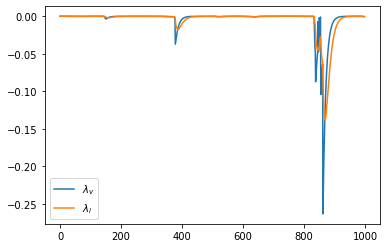

In [148]:
import matplotlib.pyplot as plt

plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.plot(lambda_is[-2][:,0], label='$\lambda_i$')
plt.legend()

## Step 2.2: Learning target spike times

Another task is for one neuron to spike at specific spike times $t_0, \ldots, t_N$ given that it stimulated 
by a fixed set of poisson distributed spikes. We can choose as a loss in this case
$$
l = \sum_i \lvert v - v_{\text{th}} \rvert^2 \delta(t - t_i) + l_N
$$
that is we require the membrane voltages to be close to the threshold $v_{th}$ at the required spike times $t_i$
and penalise the neuron if it spikes more or less than the required number of times.

In [149]:
from tqdm.notebook import trange

def run_target_spike_time_training(
    w_in,
    z_in,
    alpha=100.0,
    epochs=4000,
):
    neurons = Neurons(w_in, alpha=torch.tensor(alpha))
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []
    

    v_target = torch.zeros(seq_length, batch_size, hidden_size)
    target_times = [100, 300, 500, 700]
    target_spikes = len(target_times)

    for time in target_times:  
        v_target[time,:] =  torch.ones(hidden_size)
    
    pbar = trange(epochs)
    for e in pbar:
        optim.zero_grad()

        z_s, voltages, currents = neurons(z_in)
        loss = torch.zeros(1,1)
        for time in target_times:    
            loss += 1/2 * 1/10 * (voltages[time,:] - v_target[time,:])**2

        dspikes = torch.sum(torch.abs(torch.sum(z_s, axis=0) - target_spikes))
        loss += dspikes
        loss.backward()

        pbar.set_postfix({"loss": loss.detach().item(), "dspikes": dspikes.detach().item()})

        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))

        neurons.lambda_vs = []
        neurons.lambda_is = []
        if loss.data == torch.tensor([0.0]):
            break

        optim.step()

    return spikes_out, vs, vs, lambda_vs, lambda_is

In [150]:
seq_length = 1000
input_size = 50
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0

w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
result = run_target_spike_time_training(w_in=w_in, z_in=z_in, alpha=alpha, epochs=epochs)

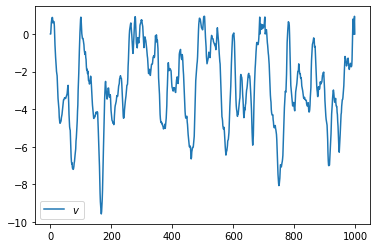

In [151]:
spikes, vs, cs, lambda_vs, lambda_is = result

plt.plot(vs[-1][:,0], label='$v$')
plt.legend()

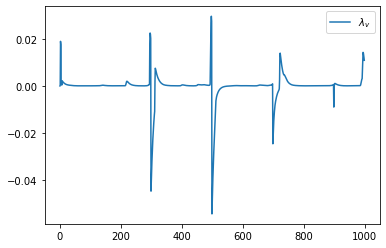

In [152]:
plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.legend()